In [1]:
import numpy as np

GAMMA = 0.93
MEMORY_SIZE = 70000
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.02
EXPLORATION_DECAY = 0.99
MAX_NUMBER_OF_EPISODES_FOR_TRAINING = 600
LEARN_BATCH = 4
CENTRO_X = 128
AREA_IDEAL = 12000
INTERVALO_AREA = 2000
INTERVALO_X = 40
LOWER_RED = np.array([0, 0, 50])
UPPER_RED = np.array([50, 50, 255])

In [2]:
import keras
import random
import matplotlib.pyplot as plt


class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size % MEMORY_SIZE
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states
        
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # Neural model
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(40, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(500, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(750, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(500, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

        # Neural model target
        self.model_target = keras.models.Sequential()
        self.model_target.add(keras.layers.Dense(40, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(500, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(750, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(500, activation="relu",kernel_initializer="he_normal"))
        self.model_target.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model_target.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state, exploration_rate):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def select_greedy_policy(self, state):
        # Generate an action for a given state using greedy policy
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def learn(self, learn : bool):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model_target(states).numpy()
        q_next_states = self.model_target(next_states).numpy()

        for i in range(BATCH_SIZE):
            if (terminal_states[i]):
                q_targets[i][actions[i]] = rewards[i]
            else:
                q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

        if learn:
            weights = self.model.get_weights()
            self.model_target.set_weights(weights)

In [3]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

class Coppelia():

    def __init__(self):
        client = RemoteAPIClient()
        self.sim = client.getObject('sim')
        
    def start_simulation(self):
        self.default_idle_fps = self.sim.getInt32Param(self.sim.intparam_idle_fps)
        self.sim.setInt32Param(self.sim.intparam_idle_fps, 0)
        self.sim.startSimulation()

    def stop_simulation(self):
        self.sim.stopSimulation()
        while self.sim.getSimulationState() != self.sim.simulation_stopped:
            time.sleep(0.1)
        self.sim.setInt32Param(self.sim.intparam_idle_fps, self.default_idle_fps)

    def is_running(self):
        return self.sim.getSimulationState() != self.sim.simulation_stopped
    
class State():
    def __init__(self):
        self.fordward_metrics = 0
        self.rectangle_height = 0
        self.rectangle_width = 0
        self.rectangle_x = 0
        self.circle_x = 0 
        self.rectangle_y = 0
        self.circle_y = 0 
        self.circle_area = 0

    def set(self, position):
        self.rectangle_x, self.rectangle_y, self.rectangle_width, self.rectangle_height = position
        return self

    def update(self):
        if self.rectangle_x == -10:
            self.circle_x = -10
            self.circle_y = -10
            self.circle_area = -10
        else:
            self.circle_x = self.rectangle_x + max(self.rectangle_width , self.rectangle_height) / 2
            self.circle_y = self.rectangle_y + max(self.rectangle_height, self.rectangle_width) / 2
            self.circle_area = np.pi * (max(self.rectangle_width, self.rectangle_height) / 2) ** 2

    #State use coordinates of the center of the circle (x, y), the area of the circle

    def list_state(self):
        self.update()
        return np.array([[self.circle_x, self.circle_y, self.circle_area]])

class P3DX():
    num_sonar = 16
    sonar_max = 1.0
    lower_red = np.array([0, 0, 50])
    upper_red = np.array([0, 0, 255])

    def __init__(self, sim, robot_id) -> None:
        self.sim = sim
        self.left_motor = self.sim.getObject(f'/{robot_id}/leftMotor')
        self.right_motor = self.sim.getObject(f'/{robot_id}/rightMotor')
        self.sonar = [self.sim.getObject(f'/{robot_id}/visible/ultrasonicSensor[{idx}]') for idx in range(self.num_sonar)]
        self.vision_sensor = self.sim.getObject(f'/{robot_id}/camera')
        self.learning_network = DQN(3, 7)
        self.state = State()
        self.readings = self.get_sonar()
        self.imgs = []
        
    def get_sonar(self):
        readings = []
        for i in range(self.num_sonar):
            res, dist, _, _, _ = self.sim.readProximitySensor(self.sonar[i])
            readings.append(dist if res == 1 else self.sonar_max)
        return readings

    def get_vision(self):
        img, [resX, resY] = self.sim.getVisionSensorImg(self.vision_sensor)
        return img, resX, resY
    
    def get_ball_position(self):
        img, resX, resY = self.get_vision()
        img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
        img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
        self.imgs.append(img)
        mask = cv2.inRange(img, LOWER_RED, UPPER_RED)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        positions = []
        
        for contour in contours:
            # Calcular el rectángulo envolvente
            x, y, w, h = cv2.boundingRect(contour)
            # Dibujar el rectángulo
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)
            positions.append((x, y, w, h))
        if positions == []:
            positions.append((-10, -10, -10, -10))
        cv2.imshow("Robot's POV", img)
        cv2.waitKey(1)
        return positions[0]


    def get_action(self, exploration_rate, test: bool = False):
        if not test:
            return self.learning_network.select(self.state.list_state(), exploration_rate)
        else:
            return self.learning_network.select_greedy_policy(self.state.list_state())

    def set_speed(self, action):
        if action == 0:
            ispeed, rspeed = self.turn_right(0.3)
        if action == 1:
            ispeed, rspeed = self.turn_right(1.5)
        if action == 2:
            ispeed, rspeed = self.move_forward()
        if action == 3:
            ispeed, rspeed = self.move_forward_fast()
        if action == 4:
            ispeed, rspeed = self.turn_left(1.5)
        if action == 5:
            ispeed, rspeed = self.turn_left(0.3)
        if action == 6:
            ispeed, rspeed = self.move_backward()
        self.sim.setJointTargetVelocity(self.left_motor, ispeed)
        self.sim.setJointTargetVelocity(self.right_motor, rspeed)

    def move_forward_fast(self):
        ispeed, rspeed = 2.5, 2.5
        return ispeed, rspeed
    
    def move_forward(self):
        ispeed, rspeed = 1.5, 1.5
        return ispeed, rspeed

    def move_backward(self):
        ispeed, rspeed = -0.5, -0.5
        return ispeed, rspeed

    def turn_right(self, grade):
        ispeed, rspeed = 2.5, grade
        return ispeed, rspeed

    def turn_left(self, grade):
        ispeed, rspeed = grade, 2.5
        return ispeed, rspeed

    def get_metrics(self, readings):
        pass

    def get_state(self):
        position = self.get_ball_position()
        self.state = self.state.set(position)
        self.state.update()
        return self.state.list_state()

class environment():
    def __init__(self, robot_id, sim):
        self.actions = [0, 1, 2, 3, 4, 5, 6] # 0: right, 1: fordward-right, 2:fordward , 3: fordward-fast, 4: fordward_left, 5: left 6: backward
        self.number_of_observations = 3 #circle_x, circle_y, circle_area
        self.number_of_actions = 7
        self.robot = P3DX(sim, robot_id)

    #256 de resolución, centro x = 128, centro y = 128, area ideal = 10000 entre 8000 y 12000

    def reward(self, action):
        # Reward for right turn action
        if action == 0:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40
            else:
                reward = 5 + 0.5 * (state.circle_x - CENTRO_X) 

        # Reward for fordward-right action
        if action == 1:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40 
            else:
                reward = 5 + 0.005 * ((state.circle_x - CENTRO_X) * abs(state.circle_x - CENTRO_X))  + 0.005 * (AREA_IDEAL - state.circle_area)

        # Reward for fordward action
        if action == 2:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40
            else:
                reward = 5 + 0.001 * (AREA_IDEAL - state.circle_area) - 0.01 * (abs(CENTRO_X - state.circle_x) ** 2)

        # Reward for fordward-fast action
        if action == 3:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40
            else:
                reward = 5 + 0.005 * (AREA_IDEAL - state.circle_area) - 0.009 * (abs(CENTRO_X - state.circle_x) **2)

        # Reward for fordward-left action
        if action == 4:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40
            else:
                reward = 5 + 0.005 * ((CENTRO_X - state.circle_x) * abs(CENTRO_X - state.circle_x)) + 0.005 * (AREA_IDEAL - state.circle_area)

        # Reward for left turn action
        if action == 5:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40
            else:
                reward = 5 + 0.5 * (CENTRO_X - state.circle_x)

        # Reward for backward action
        if action == 6:
            state = self.robot.state
            if state.circle_area < 0:
                reward = -40
            else:
                reward = 5 + 0.005 * (state.circle_area - (AREA_IDEAL + INTERVALO_AREA))

        return reward
    

[[0.21542175 0.59223715 0.04872756 0.2711621 0.25 0.75 0.75]]

In [4]:
def writte_log(state, action, reward, score, episode, step):
    with open("log.csv", "a") as file:
        file.write(f"State: {state}, Action: {action}, Reward: {reward}, Score: {score}, Episode: {episode}, Step: {step}\n")

def writte_log_test(state, action, reward, score, episode, step):
    with open("log_test.csv", "a") as file:
        file.write(f"State: {state}, Action: {action}, Reward: {reward}, Score: {score}, Episode: {episode}, Step: {step}\n")

In [13]:
cv2.destroyAllWindows()

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

coppelia = Coppelia()
env = environment(robot_id= "PioneerP3DX", sim=coppelia.sim)
robot = env.robot
robot.state = State()

# readings = []
ball_metrics = []
coppelia.start_simulation()

episode = 0
# start_time = time.perf_counter()
total_steps = 1
exploration_rate = EXPLORATION_MAX
goal_reached = False
learn_batch = 0
while (episode < 1) and coppelia.is_running():
    episode += 1
    steps = 1
    score = 0
    state = robot.get_state()
    end_episode = False
    while steps < 6000:
        learn_batch +=1
        # Select an action for the current state
        action = robot.get_action(exploration_rate, test=False)

       # Execute the action on the environment
        reward = env.reward(action)

        print(reward, state, action)

        robot.set_speed(action)
        state_next = robot.get_state()

        # Store in memory the transition (s,a,r,s')
        robot.learning_network.remember(state, action, reward, state_next, False)

        score += reward

        # Learn using a batch of experience stored in memory
        if learn_batch == LEARN_BATCH:
            robot.learning_network.learn(True)
            learn_batch = 0
        else:
            robot.learning_network.learn(False)

        state = state_next
        total_steps += 1
        steps += 1

        writte_log(state, action, reward, score, episode, steps)

    # Decrease exploration rate
        exploration_rate *= EXPLORATION_DECAY
        exploration_rate = max(EXPLORATION_MIN, exploration_rate)
        
coppelia.stop_simulation()

cv2.destroyAllWindows()


-25 [[-10 -10 -10]] 4
-15 [[-10 -10 -10]] 5
-25 [[-10 -10 -10]] 4
71.51949397939059 [[ 263.5         125.5        1452.20120412]] 3
1/1 [==============================] - 0s 389ms/step
69.52279504841363 [[ 244.5         125.5        1885.74099032]] 3
-35.491650311182624 [[ 209.5         123.5        4901.66993776]] 6
55.80501324974671 [[ 206.5         123.5        5152.99735005]] 4
-34.23501324974671 [[ 204.5         122.5        5152.99735005]] 6
54.25696026177489 [[ 193.5         122.5        5410.60794765]] 4
25.908230559067608 [[ 177.          122.         5541.76944093]] 2
13.941769440932394 [[ 168.          123.         5541.76944093]] 5
51.631152795338025 [[ 161.          122.         5541.76944093]] 1
13.439501730546564 [[ 151.5         122.5        5674.50173055]] 0
13.958804816487525 [[ 143.          122.         5808.80481649]] 5
13.849678698755287 [[ 137.5         122.5        5944.67869876]] 0
49.4093831132508 [[ 119.          122.         6082.12337735]] 4
48.71137438240

In [5]:
coppelia = Coppelia()
env = environment(robot_id= "PioneerP3DX", sim=coppelia.sim)
robot = env.robot
robot.state = State()

C:\Users\mario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

actions = {0: 0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
scores = []
ball_metrics = []

episode = 0
total_steps = 1
exploration_rate = EXPLORATION_MAX
goal_reached = False
learn_batch = 0
while (episode < 7):
    coppelia.start_simulation()
    while coppelia.is_running():
        episode += 1
        steps = 1
        score = 0
        state = robot.get_state()
        end_episode = False
        while steps < 3000:
            learn_batch +=1
            # Select an action for the current state
            action = robot.get_action(exploration_rate, test=False)

            # Execute the action on the environment
            reward = env.reward(action)
            actions[action] += reward

            print(reward, state, action)

            robot.set_speed(action)
            state_next = robot.get_state()

            # Store in memory the transition (s,a,r,s')
            robot.learning_network.remember(state, action, reward, state_next, False)

            score += reward

            # Learn using a batch of experience stored in memory
            if learn_batch == LEARN_BATCH:
                robot.learning_network.learn(True)
                learn_batch = 0
            else:
                robot.learning_network.learn(False)

            writte_log(state, action, reward, score, episode, steps)
            
            state = state_next
            total_steps += 1
            steps += 1



    # Decrease exploration rate
            exploration_rate *= EXPLORATION_DECAY
            exploration_rate = max(EXPLORATION_MIN, exploration_rate)
        
        coppelia.stop_simulation()
        scores.append(score)

cv2.destroyAllWindows()

-40 [[-10 -10 -10]] 2
-30.30110914110073 [[ 253.          123.         6939.77817178]] 6
60.25 [[ 238.5         121.5        6792.90871522]] 0
-48.75 [[ 235.5         121.5        6792.90871522]] 5
53.25 [[ 224.5         122.5        6503.88219109]] 0
-9.380660955471342 [[ 219.5         122.5        6503.88219109]] 4
70.17137438240334 [[ 214.          122.         6361.72512352]] 1
0.8793390445286562 [[ 207.5         123.5        6503.88219109]] 4
15.949339044528656 [[ 185.5         122.5        6503.88219109]] 4
-32.48058904452866 [[ 183.5         122.5        6503.88219109]] 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
-32.48058904452866 [[ 186.5         122.5        6503.88219109]] 6
38.690798286177866 [[  97.          123.         4300.84034276]] 1
50.37431593627498 [[  92.5         123.5        4185.38681275]] 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
37.77181593627498 [[  92.5         123.5        4185.38681275]] 1
12.92849592094763 [[ 128.          123.         4071.50407905]] 2
44.32

KeyboardInterrupt: 

In [69]:
actions

{0: -529.905,
 1: -2553.23,
 2: 273081.3620519865,
 3: -1851.1302219896615,
 4: -4156.684999999999,
 5: -142931.945,
 6: -1035}

In [76]:
actions

{0: -5735.43,
 1: -7925,
 2: -2779.668836577474,
 3: 55437.987272640996,
 4: -8708.185000000007,
 5: -56473.575,
 6: -3684.3211388745954}

In [68]:
scores

[15685.293531039935,
 14754.908963194875,
 32740.267156429756,
 27058.020121805843,
 29784.97705752672]

In [8]:
robot.learning_network.model.save("model2.h5")

C:\Users\mario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
ball_metrics

[[123.0, 125.0, 4778.362426110075],
 [52.5, 125.5, 3525.6523554911455],
 [107.5, 99.5, 0.7853981633974483],
 [153.5, 126.5, 1734.9445429449634],
 [148.5, 127.5, 1320.2543126711105],
 [78.0, 127.0, 1134.1149479459152],
 [24.0, 128.0, 1134.1149479459152],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [239.5, 54.5, 855.2985999398212],
 [248.0, 69.0, 3.141592653589793],
 [187.5, 84.5, 0.7853981633974483],
 [61.5, 126.5, 3959.1921416865366],
 [76.0, 126.0, 2642.079421669016],
 [141.5, 126.5, 1885.7409903172734],
 [162.0, 127.0, 1385.4423602330987],
 [108.5, 126.5, 1194.5906065275187],
 [56.0, 128.0, 1134.1149479459152],
 [16.5, 127.5, 855.2985999398212],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -10, -10],
 [-10, -1

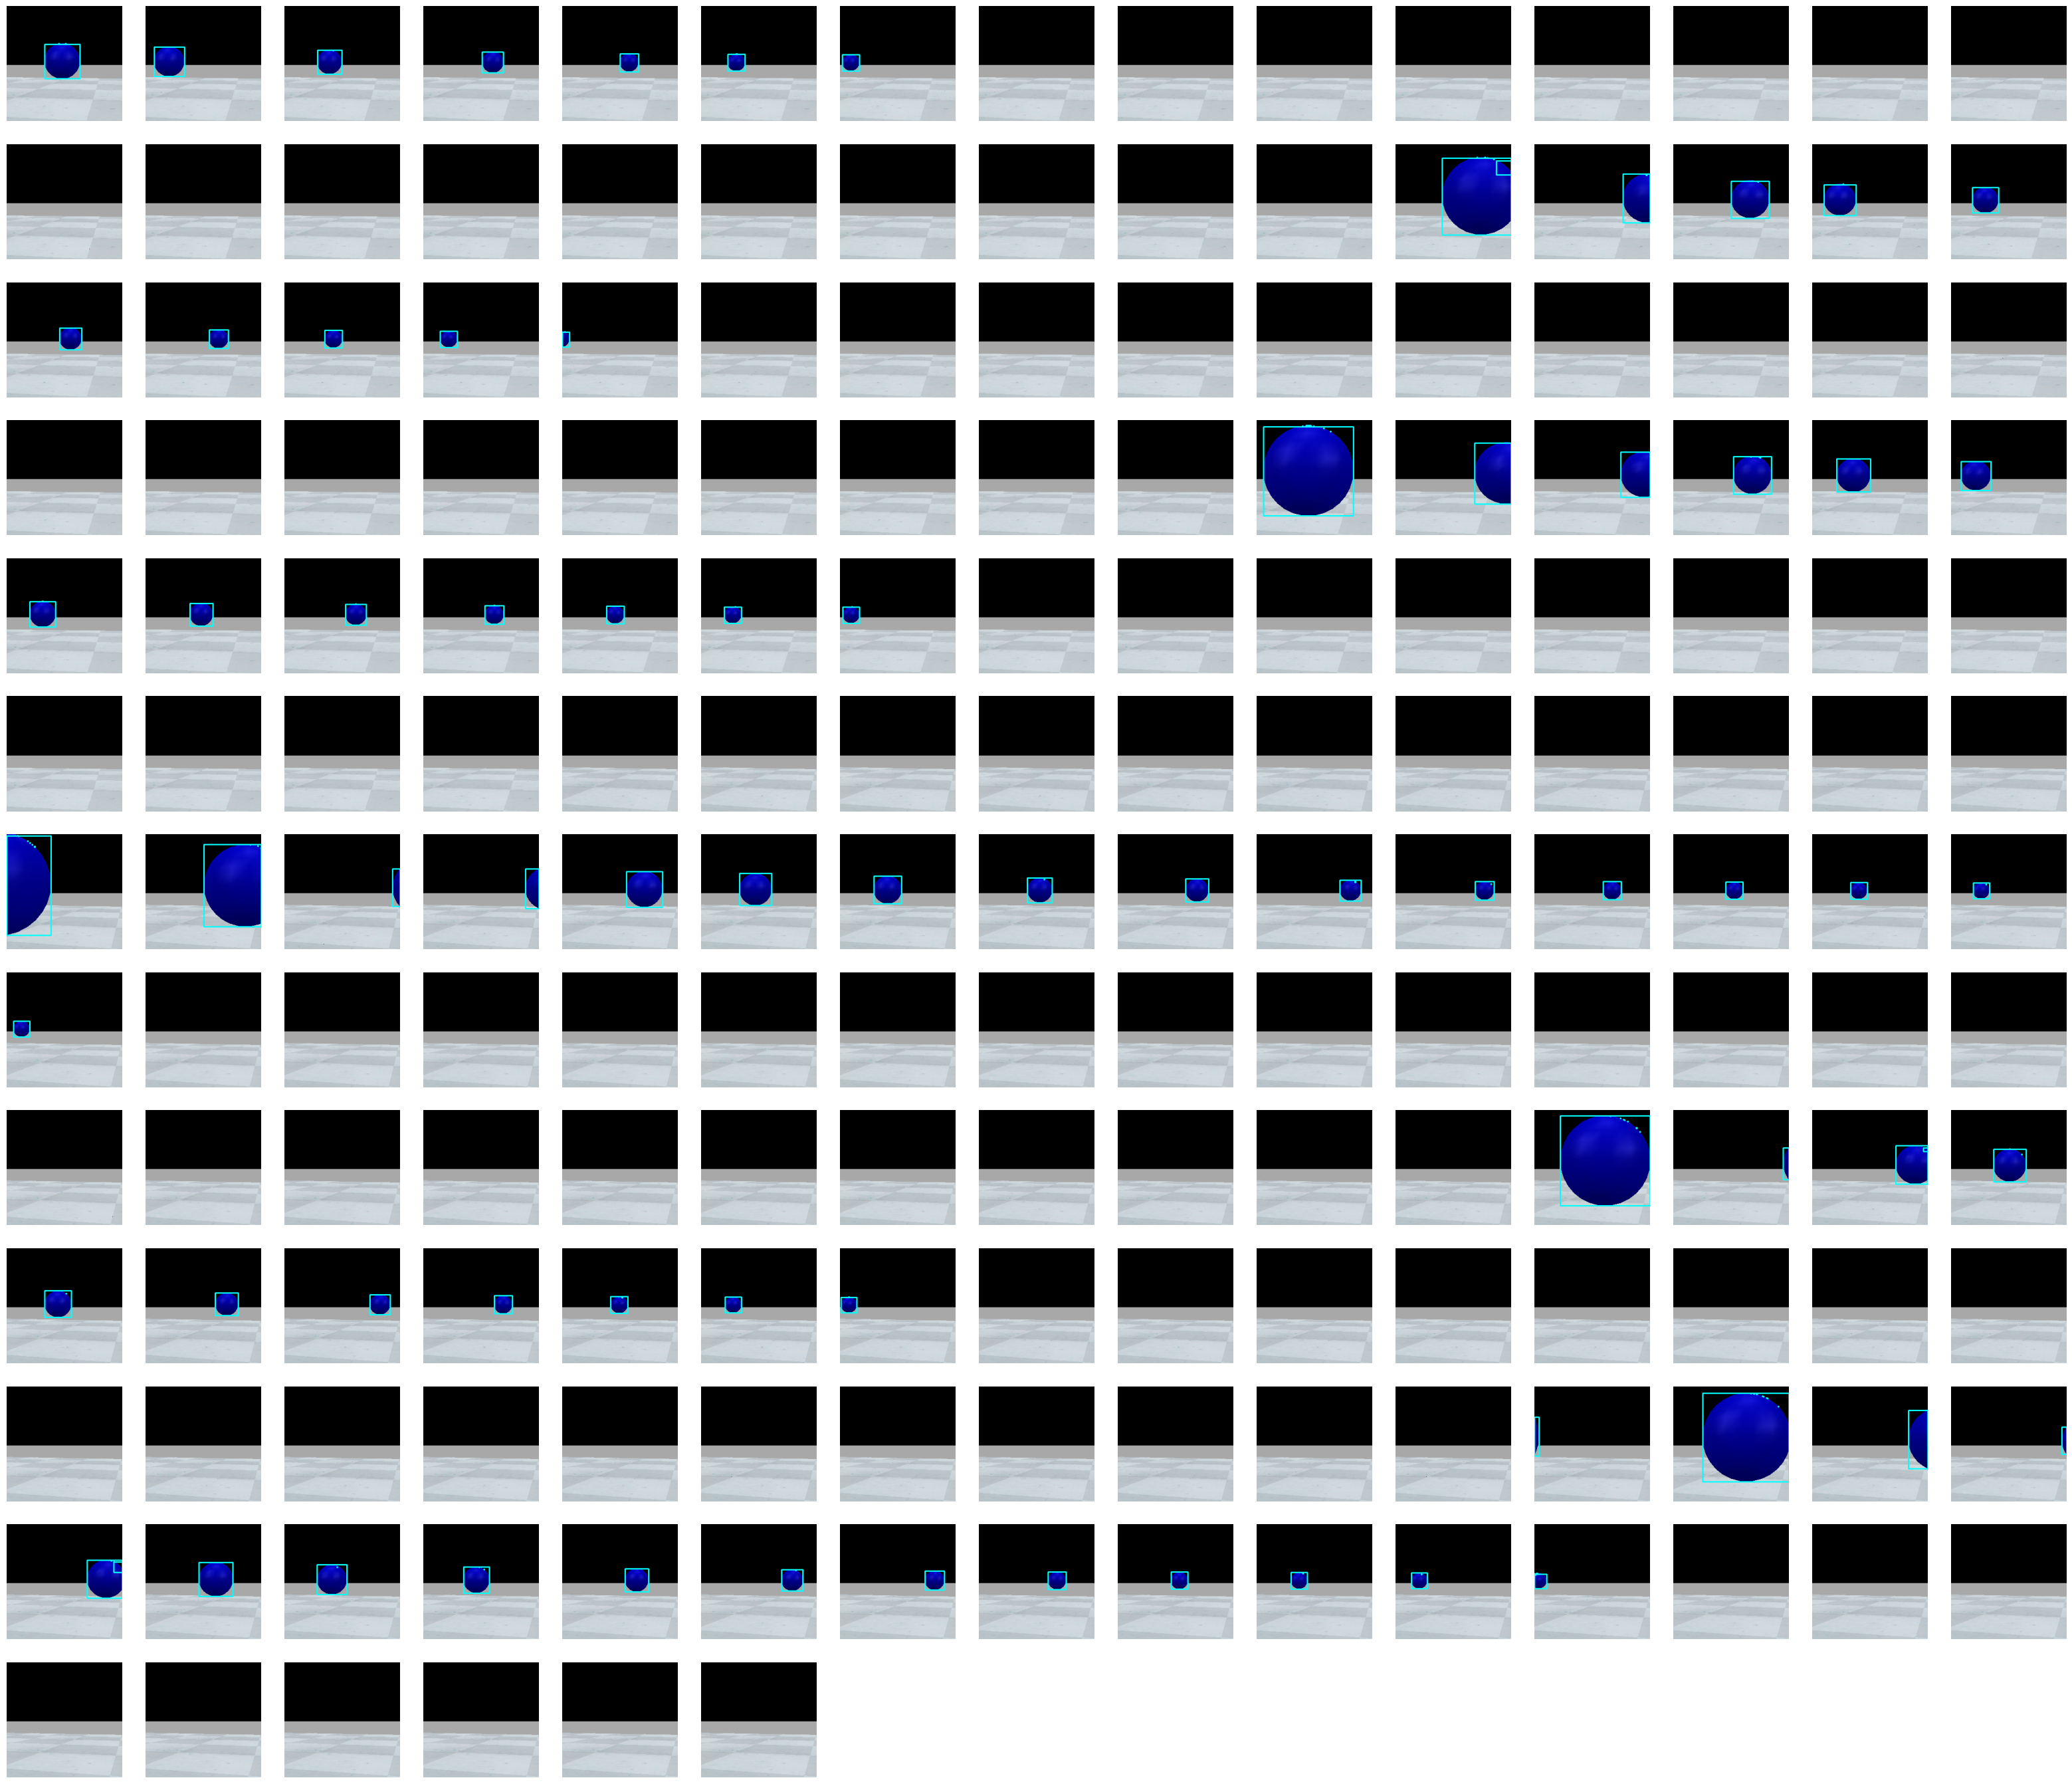

In [7]:
plt.figure(figsize=(40, 40))
for i, img in enumerate(robot.imgs):
    plt.subplot(15, 15, i+1)
    plt.imshow(img)
    plt.axis("off")

TEST

In [ ]:
coppelia.start_simulation()

score = 0
episode = 0
# start_time = time.perf_counter()
total_steps = 1
goal_reached = False
while (episode < 2) and coppelia.is_running():
    episode += 1
    steps = 1
    score = 0
    state = robot.get_state()
    count_action = 1
    last_action = None
    end_episode = False
    while steps < 2000:
        learn_batch +=1
        # Select an action for the current state
        action = robot.get_action(exploration_rate, test=True)

       # Execute the action on the environment
        reward = env.reward(count_action, action)
        print(reward, state, action)

        robot.set_speed(action)
        state_next = robot.get_state()
        print(state, steps, action)

        score += reward

        state = state_next
        last_action = action
        total_steps += 1
        steps += 1

        writte_log_test(state, action, reward, score, episode, steps)

coppelia.stop_simulation()

In [6]:
import pandas as pd

log = pd.read_csv("scores_buenos_test.csv", sep=",")
log

,State,Action,Reward,Score,Episode,Step
0,State: [[-10 -10 -10]],Action: 1,Reward: -25,Score: -25,Episode: 1,Step: 2
1,State: [[-10 -10 -10]],Action: 1,Reward: -25,Score: -50,Episode: 1,Step: 3
2,State: [[-10 -10 -10]],Action: 2,Reward: -25,Score: -75,Episode: 1,Step: 4
3,State: [[-10 -10 -10]],Action: 6,Reward: -25,Score: -100,Episode: 1,Step: 5
4,State: [[-10 -10 -10]],Action: 2,Reward: -25,Score: -125,Episode: 1,Step: 6
...,...,...,...,...,...,...
35774,State: [[ 69. 122. 6647.610055]],Action: 2,Reward: 25.37827487648067,Score: 18370.150957790207,Episode: 5,Step: 3996
35775,State: [[ 46.5 121.5 6792.9087...,Action: 2,Reward: 24.997389945004,Score: 18395.148347735212,Episode: 5,Step: 3997
35776,State: [[ 48. 121. 7238.2294...,Action: 2,Reward: 24.73459128477547,Score: 18419.882939019986,Episode: 5,Step: 3998
35777,State: [[ 39. 121. 4778.3624...,Action: 2,Reward: 24.291770526129117,Score: 18444.174709546114,Episode: 5,Step: 3999


35779


<Axes: >

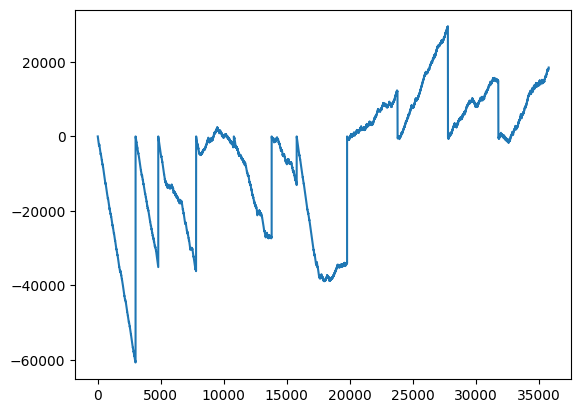

In [7]:
import pandas as pd

log = pd.read_csv("scores_buenos_test.csv", sep=",")
score = log[" Score"].dropna()

score_values = score.map(lambda x: float(x.split(":")[1].strip()))

print(score_values.count())
score_values.plot()